<a href="https://colab.research.google.com/github/mahsaa99/crypto-volatility-/blob/main/Event_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install yfinance pandas numpy matplotlib scipy statsmodels arch seaborn scikit-learn ace_tools

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from datetime import timedelta
from scipy.stats import ttest_1samp
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.4 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd

# Load data with explicit date format (MM/DD/YY)
btc_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Btc dailz till november.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'  # Replacing deprecated date_parser
)
btc_data = btc_data.sort_index()  # Ensure data is sorted by Date

eth_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/ETH daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
eth_data = eth_data.sort_index()

sp500_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Spx daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
sp500_data = sp500_data.sort_index()


# Restrict the time span to 01.2018–09.2024
btc_data = btc_data.loc['2017-01-01':'2024-09-30']
eth_data = eth_data.loc['2017-01-01':'2024-09-30']
sp500_data = sp500_data.loc['2017-01-01':'2024-09-30']


print("Data loaded, dates parsed correctly, and filtered for the specified time span.")


Data loaded, dates parsed correctly, and filtered for the specified time span.


In [ ]:
# Load the FOMC data and parse the correct date column
fed_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/fomc rate descion final edition.csv',
    parse_dates=['Date Time'],  # Use 'Date Time' as the date column
    index_col=None,            # Ensure no column is set as the index yet
    low_memory=False           # Handle mixed types in large files
)

# Normalize the 'Date Time' column to extract only the date (remove time part)
fed_data['Date'] = pd.to_datetime(fed_data['Date Time']).dt.normalize()


# Convert 'Survey', 'Actual', and 'Prior' to numeric, stripping '%' if present
fed_data['Actual'] = pd.to_numeric(fed_data['Actual'].astype(str).str.replace('%', ''), errors='coerce')
fed_data['Survey'] = pd.to_numeric(fed_data['Survey'].astype(str).str.replace('%', ''), errors='coerce')
fed_data['Prior'] = pd.to_numeric(fed_data['Prior'].astype(str).str.replace('%', ''), errors='coerce')

# Drop rows with invalid numeric values
fed_data = fed_data.dropna(subset=['Actual', 'Survey', 'Prior'])


# Calculate 'Surprise' as the difference between 'Actual' and 'Survey'
fed_data['Surprise'] = fed_data['Actual'] - fed_data['Survey']

# Define categories: Hawkish, Dovish, and No Change
fed_data['Category'] = pd.cut(
    fed_data['Actual'] - fed_data['Prior'],
    bins=[-float('inf'), -1e-9, 1e-9, float('inf')],  # Small tolerance for floating point precision
    labels=['Dovish', 'Neutral', 'Hawkish']
)


# Remove rows with duplicated dates (keeping the first occurrence)
fed_data = fed_data.drop_duplicates(subset=['Date'], keep='first')

# Verify that duplicates are removed
print(f"Data after removing duplicates (based on Date): {fed_data.shape}")
print(fed_data.head())


Data after removing duplicates (based on Date): (54, 8)
            Date Time                             Event  Survey  Actual  \
0 2018-01-31 20:00:00  FOMC Rate Decision (Upper Bound)    1.50    1.50   
2 2018-03-21 19:00:00  FOMC Rate Decision (Upper Bound)    1.75    1.75   
4 2018-05-02 20:00:00  FOMC Rate Decision (Upper Bound)    1.75    1.75   
6 2018-06-13 20:00:00  FOMC Rate Decision (Upper Bound)    2.00    2.00   
8 2018-08-01 20:00:00  FOMC Rate Decision (Upper Bound)    2.00    2.00   

   Prior       Date  Surprise Category  
0   1.50 2018-01-31       0.0  Neutral  
2   1.50 2018-03-21       0.0  Hawkish  
4   1.75 2018-05-02       0.0  Neutral  
6   1.75 2018-06-13       0.0  Hawkish  
8   2.00 2018-08-01       0.0  Neutral  


<ipython-input-4-c19edffbb727>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fed_data['Surprise'] = fed_data['Actual'] - fed_data['Survey']
<ipython-input-4-c19edffbb727>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fed_data['Category'] = pd.cut(


Skipping 2018-01-31 00:00:00 due to error: zero-size array to reduction operation maximum which has no identity
BTC CAR Statistical Significance (Lower p-value = Better MA):
BTC CAR (12-day MA): t-stat=1.6400, p-value=0.1070
BTC CAR (30-day MA): t-stat=2.0636, p-value=0.0441
BTC CAR (120-day MA): t-stat=2.2558, p-value=0.0283
BTC CAR (240-day MA): t-stat=2.6766, p-value=0.0099

ETH CAR Statistical Significance (Lower p-value = Better MA):
ETH CAR (12-day MA): t-stat=1.8899, p-value=0.0643
ETH CAR (30-day MA): t-stat=2.3340, p-value=0.0235
ETH CAR (120-day MA): t-stat=1.9701, p-value=0.0542
ETH CAR (240-day MA): t-stat=2.8190, p-value=0.0068


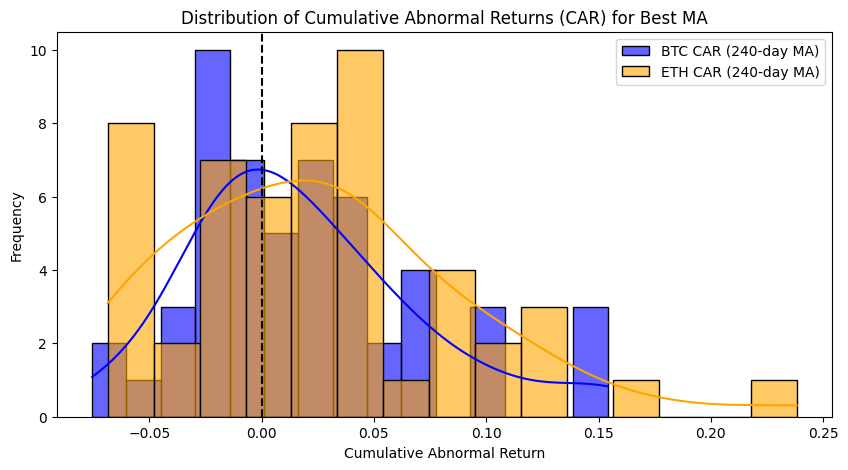

In [ ]:
# Step 1: Calculate Daily Returns
btc_data['Return'] = btc_data['Close'].pct_change()
eth_data['Return'] = eth_data['Close'].pct_change()

# Step 2: Compute Different Moving Averages for BTC
ma_periods = [12, 30, 120, 240]  # Different MA periods to test
for ma in ma_periods:
    btc_data[f'MA_{ma}'] = btc_data['Close'].rolling(window=ma).mean()
    btc_data[f'Market_{ma}'] = btc_data[f'MA_{ma}'].pct_change()

# Merge Data
crypto_data = btc_data[['Return']].rename(columns={'Return': 'BTC_Return'}).join(
    eth_data[['Return']].rename(columns={'Return': 'ETH_Return'}), how='inner'
)

# Add all market proxies (BTC MAs as market return)
for ma in ma_periods:
    crypto_data[f'Market_{ma}'] = btc_data[f'Market_{ma}']

# Drop NaN values (from rolling calculations)
crypto_data = crypto_data.dropna()

# Step 3: Define Estimation and Event Window
estimation_window = 150  # 120 trading days before event
event_window = [-1, 0, 1]  # One day before, event day, one day after

# Step 4: Estimate Market Model for BTC & ETH Using Different MAs
def estimate_market_model(asset, market, estimation_dates):
    X = sm.add_constant(market.loc[estimation_dates])  # Add constant for OLS
    y = asset.loc[estimation_dates]  # Asset returns
    model = sm.OLS(y, X).fit()  # Run OLS regression
    return model

# Step 5: Compute AR & CAR for BTC & ETH with Different MAs
event_results = []
for event_date in fed_data['Date']:
    try:
        # Define estimation period
        est_end = event_date - timedelta(days=1)
        est_start = est_end - timedelta(days=estimation_window)
        estimation_dates = crypto_data.loc[est_start:est_end].index

        # Compute Market Models for BTC and ETH using different MAs
        models = {ma: estimate_market_model(crypto_data['BTC_Return'], crypto_data[f'Market_{ma}'], estimation_dates) for ma in ma_periods}
        eth_models = {ma: estimate_market_model(crypto_data['ETH_Return'], crypto_data[f'Market_{ma}'], estimation_dates) for ma in ma_periods}

        # Compute AR and CAR for each MA
        event_dates = [event_date + timedelta(days=i) for i in event_window]
        event_returns = crypto_data.loc[event_dates]

        for ma in ma_periods:
            event_returns[f'BTC_Expected_{ma}'] = models[ma].predict(sm.add_constant(event_returns[f'Market_{ma}']))
            event_returns[f'ETH_Expected_{ma}'] = eth_models[ma].predict(sm.add_constant(event_returns[f'Market_{ma}']))

            event_returns[f'BTC_AR_{ma}'] = event_returns['BTC_Return'] - event_returns[f'BTC_Expected_{ma}']
            event_returns[f'ETH_AR_{ma}'] = event_returns['ETH_Return'] - event_returns[f'ETH_Expected_{ma}']

        # Compute Cumulative Abnormal Return (CAR)
        event_results.append({
            'Event_Date': event_date,
            **{f'BTC_CAR_{ma}': event_returns[f'BTC_AR_{ma}'].sum() for ma in ma_periods},
            **{f'ETH_CAR_{ma}': event_returns[f'ETH_AR_{ma}'].sum() for ma in ma_periods}
        })
    except Exception as e:
        print(f"Skipping {event_date} due to error: {e}")

# Convert results to DataFrame
event_results_df = pd.DataFrame(event_results)

# Step 6: Statistical Significance Testing for Different MAs
t_stats = {}
p_values = {}

for ma in ma_periods:
    t_stats[f'BTC_{ma}'], p_values[f'BTC_{ma}'] = ttest_1samp(event_results_df[f'BTC_CAR_{ma}'], 0)
    t_stats[f'ETH_{ma}'], p_values[f'ETH_{ma}'] = ttest_1samp(event_results_df[f'ETH_CAR_{ma}'], 0)

# Print best MA based on p-value
print("BTC CAR Statistical Significance (Lower p-value = Better MA):")
for ma in ma_periods:
    print(f"BTC CAR ({ma}-day MA): t-stat={t_stats[f'BTC_{ma}']:.4f}, p-value={p_values[f'BTC_{ma}']:.4f}")

print("\nETH CAR Statistical Significance (Lower p-value = Better MA):")
for ma in ma_periods:
    print(f"ETH CAR ({ma}-day MA): t-stat={t_stats[f'ETH_{ma}']:.4f}, p-value={p_values[f'ETH_{ma}']:.4f}")

# Step 7: Visualize Best MA Results
best_ma_btc = min(p_values, key=lambda x: p_values[x] if 'BTC' in x else 1)
best_ma_eth = min(p_values, key=lambda x: p_values[x] if 'ETH' in x else 1)

plt.figure(figsize=(10, 5))
sns.histplot(event_results_df[f'BTC_CAR_{best_ma_btc.split("_")[-1]}'], bins=15, kde=True, label=f"BTC CAR ({best_ma_btc.split('_')[-1]}-day MA)", color="blue", alpha=0.6)
sns.histplot(event_results_df[f'ETH_CAR_{best_ma_eth.split("_")[-1]}'], bins=15, kde=True, label=f"ETH CAR ({best_ma_eth.split('_')[-1]}-day MA)", color="orange", alpha=0.6)
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Cumulative Abnormal Returns (CAR) for Best MA")
plt.xlabel("Cumulative Abnormal Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Skipping 2018-01-31 00:00:00 due to error: zero-size array to reduction operation maximum which has no identity
BTC CAR (120-day MA) T-test: t-stat=2.2558, p-value=0.0283
ETH CAR (120-day MA) T-test: t-stat=1.9701, p-value=0.0542


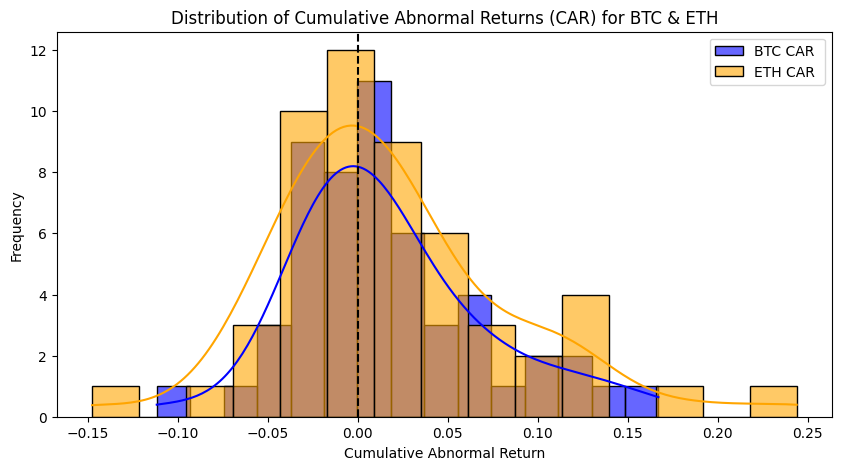

In [ ]:
# Step 1: Calculate Daily Returns
btc_data['Return'] = btc_data['Close'].pct_change()
eth_data['Return'] = eth_data['Close'].pct_change()

# Step 2: Compute the 120-day Moving Average of BTC
btc_data['MA_120'] = btc_data['Close'].rolling(window=120).mean()

# Compute market proxy return (120-day moving average return)
btc_data['Market_120'] = btc_data['MA_120'].pct_change()

# Merge Data
crypto_data = btc_data[['Return', 'Market_120']].rename(columns={'Return': 'BTC_Return'}).join(
    eth_data[['Return']].rename(columns={'Return': 'ETH_Return'}), how='inner'
)

# Drop NaN values (from rolling calculations)
crypto_data = crypto_data.dropna()

# Step 3: Define the Estimation and Event Window
estimation_window = 150  # 120 days before event
event_window = [-1, 0, 1]  # One day before, event day, one day after

# Step 4: Estimate Market Model for BTC & ETH
def estimate_market_model(asset, market, estimation_dates):
    X = sm.add_constant(market.loc[estimation_dates])  # Add constant for OLS
    y = asset.loc[estimation_dates]  # Asset returns
    model = sm.OLS(y, X).fit()  # Run OLS regression
    return model

# Step 5: Compute Abnormal Returns (AR) and Cumulative Abnormal Returns (CAR)
event_results = []

for event_date in fed_data['Date']:
    try:
        # Define estimation period
        est_end = event_date - timedelta(days=1)
        est_start = est_end - timedelta(days=estimation_window)
        estimation_dates = crypto_data.loc[est_start:est_end].index

        # Estimate Market Model for BTC (using 120-day MA)
        btc_model_120 = estimate_market_model(crypto_data['BTC_Return'], crypto_data['Market_120'], estimation_dates)

        # Estimate Market Model for ETH (using BTC 120-day MA)
        eth_model_120 = estimate_market_model(crypto_data['ETH_Return'], crypto_data['Market_120'], estimation_dates)

        # Compute AR for BTC and ETH using 120-day MA
        event_dates = [event_date + timedelta(days=i) for i in event_window]
        event_returns = crypto_data.loc[event_dates]

        # Expected returns
        event_returns['BTC_Expected_120'] = btc_model_120.predict(sm.add_constant(event_returns['Market_120']))
        event_returns['ETH_Expected_120'] = eth_model_120.predict(sm.add_constant(event_returns['Market_120']))

        # Compute Abnormal Returns (AR)
        event_returns['BTC_AR_120'] = event_returns['BTC_Return'] - event_returns['BTC_Expected_120']
        event_returns['ETH_AR_120'] = event_returns['ETH_Return'] - event_returns['ETH_Expected_120']

        # Compute Cumulative Abnormal Returns (CAR)
        btc_CAR_120 = event_returns['BTC_AR_120'].sum()
        eth_CAR_120 = event_returns['ETH_AR_120'].sum()

        # Store results
        event_results.append({
            'Event_Date': event_date,
            'BTC_CAR_120': btc_CAR_120,
            'ETH_CAR_120': eth_CAR_120
        })
    except Exception as e:
        print(f"Skipping {event_date} due to error: {e}")

# Convert results to DataFrame
event_results_df = pd.DataFrame(event_results)

# Step 6: Statistical Significance Testing
btc_t_stat_120, btc_p_value_120 = ttest_1samp(event_results_df['BTC_CAR_120'], 0)
eth_t_stat_120, eth_p_value_120 = ttest_1samp(event_results_df['ETH_CAR_120'], 0)

# Print results
print(f"BTC CAR (120-day MA) T-test: t-stat={btc_t_stat_120:.4f}, p-value={btc_p_value_120:.4f}")
print(f"ETH CAR (120-day MA) T-test: t-stat={eth_t_stat_120:.4f}, p-value={eth_p_value_120:.4f}")

# Step 7: Visualize Results
plt.figure(figsize=(10, 5))
sns.histplot(event_results_df['BTC_CAR_120'], bins=15, kde=True, label="BTC CAR ", color="blue", alpha=0.6)
sns.histplot(event_results_df['ETH_CAR_120'], bins=15, kde=True, label="ETH CAR ", color="orange", alpha=0.6)
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Cumulative Abnormal Returns (CAR) for BTC & ETH")
plt.xlabel("Cumulative Abnormal Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
# Step 1: Compute Summary Statistics for BTC and ETH CAR (120-day MA)
btc_car_120 = event_results_df['BTC_CAR_120']
eth_car_120 = event_results_df['ETH_CAR_120']

# Compute summary statistics
btc_stats = {
    "Mean CAR": np.mean(btc_car_120),
    "Std. Dev": np.std(btc_car_120, ddof=1),  # Sample std deviation
    "Min CAR": np.min(btc_car_120),
    "Max CAR": np.max(btc_car_120),
    "T-Statistic": ttest_1samp(btc_car_120, 0)[0],
    "P-Value": ttest_1samp(btc_car_120, 0)[1]
}

eth_stats = {
    "Mean CAR": np.mean(eth_car_120),
    "Std. Dev": np.std(eth_car_120, ddof=1),
    "Min CAR": np.min(eth_car_120),
    "Max CAR": np.max(eth_car_120),
    "T-Statistic": ttest_1samp(eth_car_120, 0)[0],
    "P-Value": ttest_1samp(eth_car_120, 0)[1]
}

# Step 2: Convert stats to a DataFrame for easy display
summary_stats_df = pd.DataFrame([btc_stats, eth_stats], index=['BTC (120-day MA)', 'ETH (120-day MA)'])

# Print the summary statistics
print("\nSummary Statistics for BTC and ETH CAR (120-day MA):\n")
print(summary_stats_df.to_string())  # Ensures full table is printed



Summary Statistics for BTC and ETH CAR (120-day MA):

                  Mean CAR  Std. Dev   Min CAR   Max CAR  T-Statistic   P-Value
BTC (120-day MA)  0.016696  0.053883 -0.111630  0.167143     2.255819  0.028315
ETH (120-day MA)  0.018165  0.067125 -0.147541  0.243971     1.970080  0.054165


In [ ]:
# Step 1: Merge event study results with FOMC categories and surprise
event_results_df = event_results_df.merge(
    fed_data[['Date', 'Category', 'Surprise']],
    left_on='Event_Date',
    right_on='Date',
    how='left'
).drop(columns=['Date'])

# Step 2: Print the first few rows to check if the merge was successful
print("\nEvent Study Results with FOMC Category & Surprise:\n")
print(event_results_df.head().to_string())  # Print full rows without truncation



Event Study Results with FOMC Category & Surprise:

  Event_Date  BTC_CAR_120  ETH_CAR_120 Category  Surprise
0 2018-03-21     0.087163     0.072831  Hawkish       0.0
1 2018-05-02     0.062118     0.086044  Neutral       0.0
2 2018-06-13     0.007677     0.024067  Hawkish       0.0
3 2018-08-01    -0.111630    -0.147541  Neutral       0.0
4 2018-09-26     0.014560     0.000394  Hawkish       0.0


<ipython-input-19-8e5e3d6e529e>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_summary = event_results_df.groupby('Category')[['BTC_CAR_120', 'ETH_CAR_120']].agg(['mean', 'std', 'count'])
<ipython-input-19-8e5e3d6e529e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Category", y="BTC_CAR_120", data=event_results_df, palette="Blues", width=0.6)



Mean CAR by FOMC Category (Hawkish, Neutral, Dovish):

         BTC_CAR_120                 ETH_CAR_120                
                mean       std count        mean       std count
Category                                                        
Dovish      0.041940  0.044754     5    0.045955  0.059624     5
Neutral     0.010415  0.050695    33    0.004463  0.057180    33
Hawkish     0.022102  0.063133    15    0.039045  0.084032    15

BTC CAR ANOVA p-value: 0.4363 (Significance Test for Differences Across Categories)
ETH CAR ANOVA p-value: 0.1593 (Significance Test for Differences Across Categories)


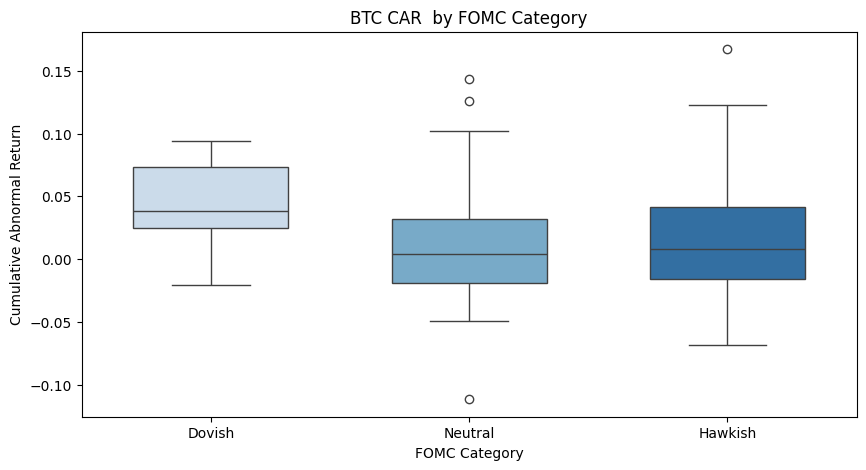

<ipython-input-19-8e5e3d6e529e>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Category", y="ETH_CAR_120", data=event_results_df, palette="Oranges", width=0.6)


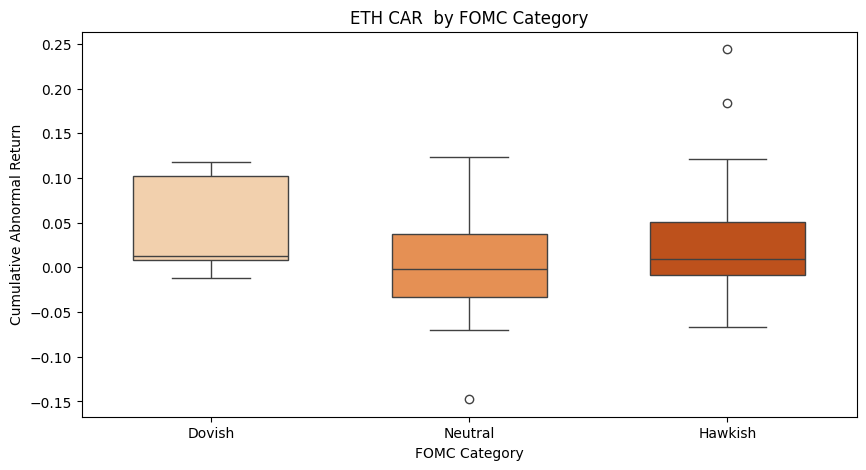


Correlation between FOMC Surprise and BTC CAR: -0.2549
Correlation between FOMC Surprise and ETH CAR: -0.1915


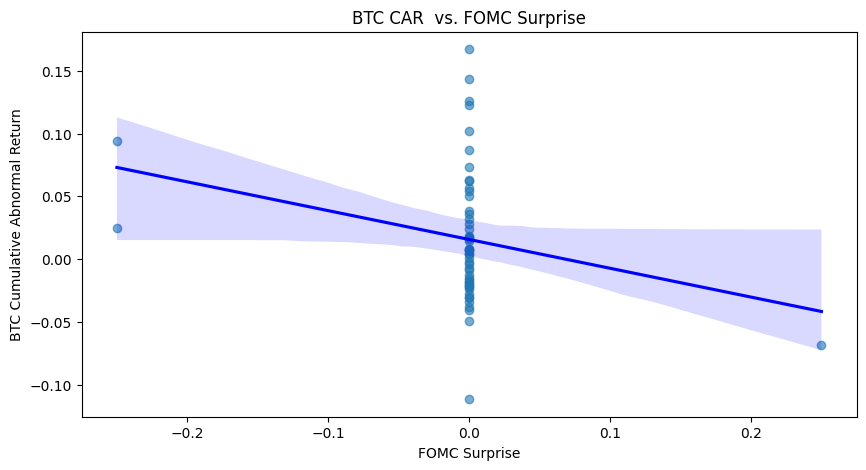

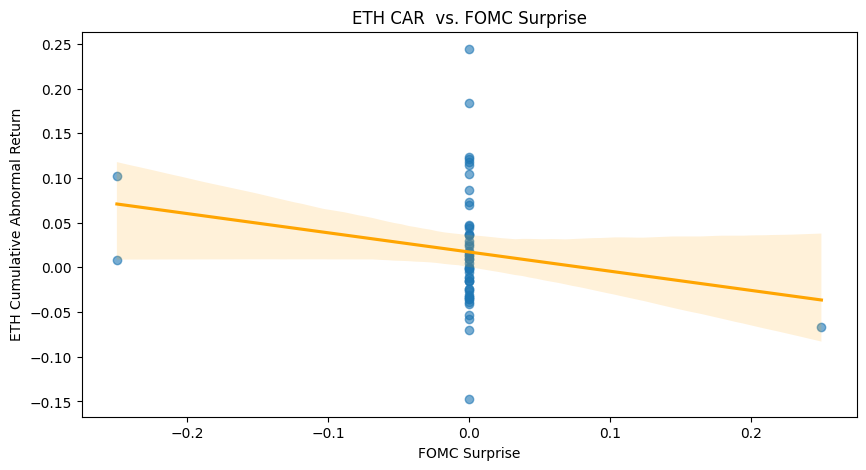


BTC CAR vs. Surprise Regression Results:
                            OLS Regression Results                            
Dep. Variable:            BTC_CAR_120   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.544
Date:                Sun, 16 Feb 2025   Prob (F-statistic):             0.0655
Time:                        11:20:12   Log-Likelihood:                 81.891
No. Observations:                  53   AIC:                            -159.8
Df Residuals:                      51   BIC:                            -155.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

### **1️⃣ Mean CAR by Category**
category_summary = event_results_df.groupby('Category')[['BTC_CAR_120', 'ETH_CAR_120']].agg(['mean', 'std', 'count'])
print("\nMean CAR by FOMC Category (Hawkish, Neutral, Dovish):\n")
print(category_summary)

# Perform ANOVA test to check if CAR differences across categories are significant
btc_anova_p = stats.f_oneway(
    event_results_df[event_results_df['Category'] == 'Hawkish']['BTC_CAR_120'],
    event_results_df[event_results_df['Category'] == 'Neutral']['BTC_CAR_120'],
    event_results_df[event_results_df['Category'] == 'Dovish']['BTC_CAR_120']
)[1]

eth_anova_p = stats.f_oneway(
    event_results_df[event_results_df['Category'] == 'Hawkish']['ETH_CAR_120'],
    event_results_df[event_results_df['Category'] == 'Neutral']['ETH_CAR_120'],
    event_results_df[event_results_df['Category'] == 'Dovish']['ETH_CAR_120']
)[1]

print(f"\nBTC CAR ANOVA p-value: {btc_anova_p:.4f} (Significance Test for Differences Across Categories)")
print(f"ETH CAR ANOVA p-value: {eth_anova_p:.4f} (Significance Test for Differences Across Categories)")

# **Plot Mean CAR by FOMC Category**
plt.figure(figsize=(10, 5))
sns.boxplot(x="Category", y="BTC_CAR_120", data=event_results_df, palette="Blues", width=0.6)
plt.title("BTC CAR  by FOMC Category")
plt.xlabel("FOMC Category")
plt.ylabel("Cumulative Abnormal Return")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x="Category", y="ETH_CAR_120", data=event_results_df, palette="Oranges", width=0.6)
plt.title("ETH CAR  by FOMC Category")
plt.xlabel("FOMC Category")
plt.ylabel("Cumulative Abnormal Return")
plt.show()

### **2️⃣ Correlation & Regression Analysis Between Surprise and CAR**
# Compute Correlation
correlation_btc = event_results_df[['Surprise', 'BTC_CAR_120']].corr().iloc[0, 1]
correlation_eth = event_results_df[['Surprise', 'ETH_CAR_120']].corr().iloc[0, 1]

print(f"\nCorrelation between FOMC Surprise and BTC CAR: {correlation_btc:.4f}")
print(f"Correlation between FOMC Surprise and ETH CAR: {correlation_eth:.4f}")

# **Scatter Plot of Surprise vs. CAR**
plt.figure(figsize=(10, 5))
sns.regplot(x="Surprise", y="BTC_CAR_120", data=event_results_df, scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
plt.title("BTC CAR  vs. FOMC Surprise")
plt.xlabel("FOMC Surprise")
plt.ylabel("BTC Cumulative Abnormal Return")
plt.show()

plt.figure(figsize=(10, 5))
sns.regplot(x="Surprise", y="ETH_CAR_120", data=event_results_df, scatter_kws={'alpha':0.6}, line_kws={'color':'orange'})
plt.title("ETH CAR  vs. FOMC Surprise")
plt.xlabel("FOMC Surprise")
plt.ylabel("ETH Cumulative Abnormal Return")
plt.show()

# **Run Regression Analysis**
import statsmodels.api as sm

# Add constant for OLS regression
X_btc = sm.add_constant(event_results_df['Surprise'])
X_eth = sm.add_constant(event_results_df['Surprise'])

# Fit regression models
btc_regression = sm.OLS(event_results_df['BTC_CAR_120'], X_btc).fit()
eth_regression = sm.OLS(event_results_df['ETH_CAR_120'], X_eth).fit()

# Print Regression Results
print("\nBTC CAR vs. Surprise Regression Results:")
print(btc_regression.summary())

print("\nETH CAR vs. Surprise Regression Results:")
print(eth_regression.summary())


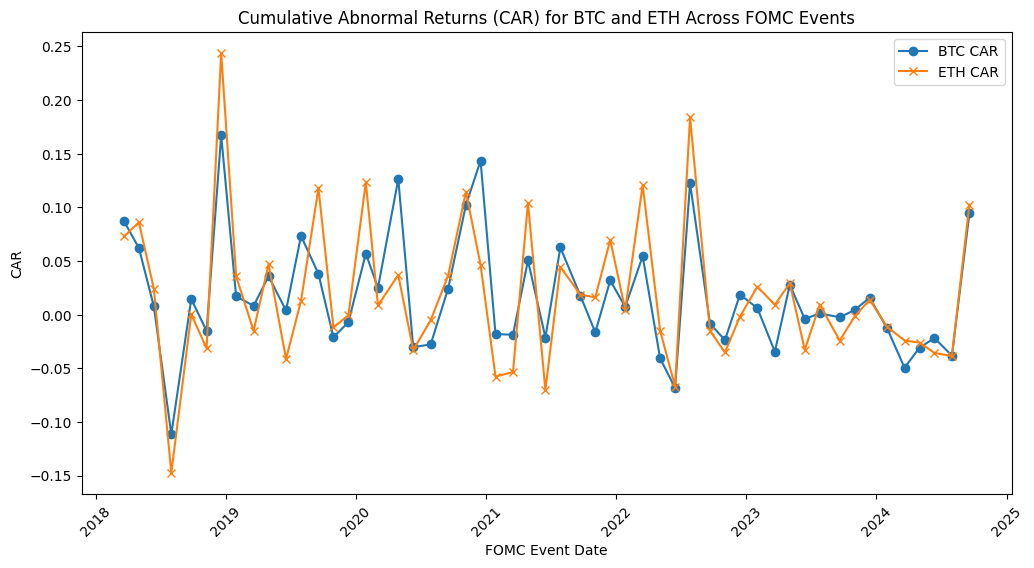

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(event_results_df['Event_Date'], event_results_df['BTC_CAR_120'], label='BTC CAR', marker='o', linestyle='-')
plt.plot(event_results_df['Event_Date'], event_results_df['ETH_CAR_120'], label='ETH CAR', marker='x', linestyle='-')

plt.title('Cumulative Abnormal Returns (CAR) for BTC and ETH Across FOMC Events')
plt.xlabel('FOMC Event Date')
plt.ylabel('CAR')
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()
